In this notebook we set up a tutorial on how to use DoWhy library for causal inference.

Through this tutorial we can get a better picture on how important causal reasoning is when it comes to taking decisions. We also step through the 4 steps involved in causal inference

We will see how powerful these libraries are in estimating causal effects just with a few lines of code.



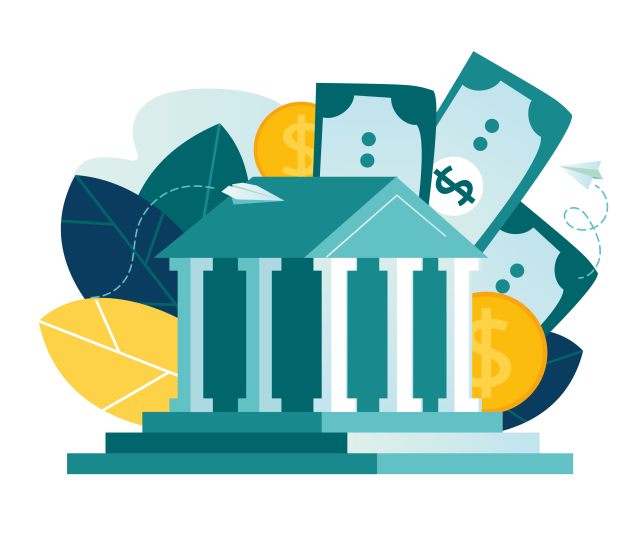

# Bank Marketing: Improving Strategies for Better Turnovers

Out of the many things that a business seem to be interested in, the most important one would be deciding on strategies that lead to a better performance for the company. In most cases, strategies are made around the existing data and insights gathered from it. This past data tells the story of how their exisiting strategies made an impact. More often than not strategists often ask the question of what the true causal effects were that lead to the current situation. Also, the next obvious question that would be asked is - What would the outcome have been if one of the previous polices were to be changed?

This is something that can be done by creating a new strategy based on previous data and recording it's outcome over the next time period. However, this clearly time consuming and costs a lot of resources with no guarantee of the outcome. A smarter way of approching would be to use the existing data and use interventions to ask the counterfactual question of If we had chosen strategy B instead what would have been the outcome. Here in this tutorial we explore how DoWhy can answer such causal inference questions.

### Summary

1. Background
2. Defining Causal Effect
3. Data
4. Exploratory Data Analysis
5. Causal Inference
  * Step 1 Modeling
  * Step 2 Identification
  * Step 3 Estimation
  * Step 4 Refutation
6. Conclusions


## Background

In our case study we have data from a bank's marketing campaign. This data provides us information on how a particular bank's marketing camapagin worked out w.r.t to obtaining customers to subscribe to a term deposit.

The data comprises of demographics of the customers and the details from the current campaign. We would like to use this data to understand the reasons why the campaign was a success to some customers and why it wasn't to others. We also ask the causal question of how **changing the campaign frequency particular user affects their chance of subscribing**. Such questions requires the use of causal inference algorithm and techniques
 

# Defining the Causal effect
In order for us to define a causal effect we need to first consider two scenarios:
1. The situation/world where the a particular set of action, say **A**=a, caused an observation say **Y**.
2. Another situation wherein we have the exact same world but we take action **A**=a' and observe **Y**.

The first situation would often be the data that we have. The second world would be called the counterfactual world. It is called so because it's a situation that is against (counter) the facts (data) that we currently have.
We can use this counterfactual world to reason about the causal relation between the variable **A** and **Y**. 

In order to have the other variable remain the constant and just change **A** we do what is called an intervention. This is given by the notation: 

$$do(A=a')$$

To estimate the extent of the causal effect we would need to calculate 

$$\mathbb{E}[Y|do(A=a)]-\mathbb{E}[Y|do(A=a')]$$

In practical experiments this would be done using randomized experiments where we have two subsets a and a'. The randomization acts like an idealized intervention. However it is not always feasible to always run such experiments due to constraints in time, money or may not even be ethically right. There could also be correlations due to circumstances prevailing at the time of data collection.
With causal inference we can remove correlations and estimate the true effect of an action.

## DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dowhy econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 52.5 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 564 kB 74.6 MB/s 
     |████████████████████████████████| 164 kB 74.4 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
warnings.simplefilter('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dowhy
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

The data is the [Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from the UCI Repository and contains ~4,000 customers and is comprised of:

<!-- * Client Demographic Data:
  1. Age: The age of the client (Numerical)
  2. Job: The current job of the Client (Categorical)
  3. Default: Does the cutomer have credit in default?
  4. Housing: Has the cumtomer taken a housing loan? (Binary)
  5. Loan: Has the cumtomer taken a personal loan? (Binary)
  6. Balance: Current balance of the customer. 
  7. Marital: Marital status of the customer. (Categorical)
  8. Education: The highest education level of the customer. (Categorical)

* Campaign Data:
  1. Campaign Frequency: The no of times the customer was contacted during the current campaign -->

| Feature Name 	| Type 	| Description                                                	|
|--------------	|------	|------------------------------------------------------------	|
| Age          	| X    	| The age of the client (Numerical)                          	|
| Education    	| X    	| The highest education level of the customer. (Categorical) 	|
| Marital      	| X    	| Marital status of the customer. (Categorical)              	|
| Job          	| W    	| The current job of the Client (Categorical)                	|
| Default      	| W    	| Does the customer have credit in default  (Binary)         	|
| Loan         	| W    	| Has the customer taken a personal loan? (Binary)           	|
| Balance      	| W    	| Current balance of the customer.                           	|
| Housing      	| W    	| Has the customer taken a housing loan? (Binary)            	|
| Campaign     	| T    	| The number of times the customer was contacted             	|
| Term         	| Y    	| Has the customer subscribed to the term loan (Binary)      	|



Client Demographic Data (**X,W**): Details about the age, job, credits and other details of each customer.<p>
Intervention (**T**): No of times the customer was contacted in the campaign.<p>
Outcome (**Y**): Has the customer subscribed to a term deposit or not

In [ ]:
# Reading the data from the file

df = pd.read_csv('/content/drive/MyDrive/CS_7290_Project/bank-full.csv', sep=";")
term_deposits = df.copy()

In [ ]:
features_under_consideration = ['age', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'balance','campaign', 'y']
       
# Checking out dataset.
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Exploratory Data Analysis

In [ ]:
df.info() # Checking for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Bar Plots for Numerical Nalues

### Age

In [ ]:
age_values = df['age'].values

99th Percentile of events 71.0
95th Percentile of events 59.0
Mean 40.93621021432837
Median 39.0
Max 95
Min 18


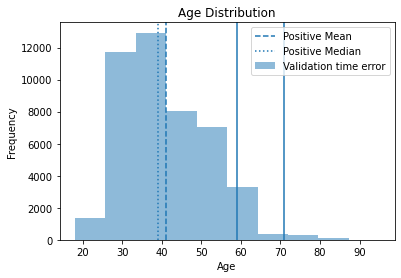

In [ ]:
fig = plt.figure()
vals = age_values
plt.hist(vals, bins = 10, alpha = 0.5, label = "Validation time error")


plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")

plt.axvline(np.percentile(vals , 99))
plt.axvline(np.percentile(vals , 95))
plt.axvline(np.mean(vals), linestyle = "--", label = "Positive Mean")
plt.axvline(np.median(vals), linestyle = ":", label = "Positive Median")

plt.legend()
display()

print("99th Percentile of events", np.percentile(vals , 99))
print("95th Percentile of events", np.percentile(vals , 95))
print("Mean", np.mean(vals))
print("Median", np.median(vals))
print("Max", np.max(vals))
print("Min", np.min(vals))

### Campaign Numbers

In [ ]:
campaign_values = df['campaign'].values

99th Percentile of events 16.0
95th Percentile of events 8.0
75th Percentile of events 3.0
Mean 2.763840658246887
Median 2.0
Max 63
Min 1


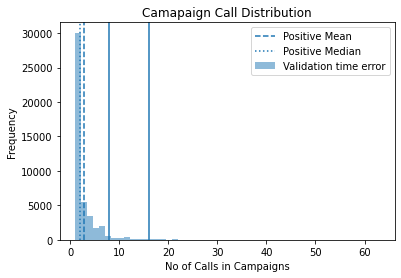

In [ ]:
fig = plt.figure()
vals = campaign_values
plt.hist(vals, bins = 50, alpha = 0.5, label = "Validation time error")


plt.xlabel("No of Calls in Campaigns")
plt.ylabel("Frequency")
plt.title("Camapaign Call Distribution")

plt.axvline(np.percentile(vals , 99))
plt.axvline(np.percentile(vals , 95))
plt.axvline(np.mean(vals), linestyle = "--", label = "Positive Mean")
plt.axvline(np.median(vals), linestyle = ":", label = "Positive Median")

plt.legend()
display()

print("99th Percentile of events", np.percentile(vals , 99))
print("95th Percentile of events", np.percentile(vals , 95))
print("75th Percentile of events", np.percentile(vals , 75))
print("Mean", np.mean(vals))
print("Median", np.median(vals))
print("Max", np.max(vals))
print("Min", np.min(vals))

In [ ]:
conditions = [
    (df['campaign'] < 3),
    (df['campaign'] >= 3) & (df['campaign'] < 6),
    (df['campaign'] >= 6)
]

values = ['Low', 'Med', 'High']

df['Campaign_Freq'] = np.select(conditions, values)

print(df)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd

In [ ]:
df['Campaign_Freq'].value_counts(), df['campaign'].value_counts()

(Low     30049
 Med     10807
 High     4355
 Name: Campaign_Freq, dtype: int64, 1     17544
 2     12505
 3      5521
 4      3522
 5      1764
 6      1291
 7       735
 8       540
 9       327
 10      266
 11      201
 12      155
 13      133
 14       93
 15       84
 16       79
 17       69
 18       51
 19       44
 20       43
 21       35
 22       23
 25       22
 23       22
 24       20
 29       16
 28       16
 26       13
 31       12
 27       10
 32        9
 30        8
 33        6
 34        5
 36        4
 35        4
 43        3
 38        3
 37        2
 50        2
 41        2
 46        1
 58        1
 55        1
 63        1
 51        1
 39        1
 44        1
 Name: campaign, dtype: int64)

## Checking Number of Unknown values in each feature

In [ ]:
for column in df.columns:
  # print(df[column].index.values)
  if 'unknown' in df[column].value_counts().index.values:
    print(f"No of unknown values in {column}:", len(df[df[column] == 'unknown']))

No of unknown values in job: 288
No of unknown values in education: 1857
No of unknown values in contact: 13020
No of unknown values in poutcome: 36959


In [ ]:
df_clean = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]

print("Before Cleaning", df.shape)
print("After Cleaning", df_clean.shape)

Before Cleaning (45211, 18)
After Cleaning (43193, 18)


Checking the no of values that are associated with fixing a term deposit.


In [ ]:
df_term_deposit_yes = df_clean[df_clean['y'] == 'yes']
df_term_deposit_no = df_clean[df_clean['y'] == 'no']

no_of_pos_depos = len(df_term_deposit_yes)
no_of_neg_depos = len(df_term_deposit_no)

People with Term Deposits 5021
People without Term Deposits 38172


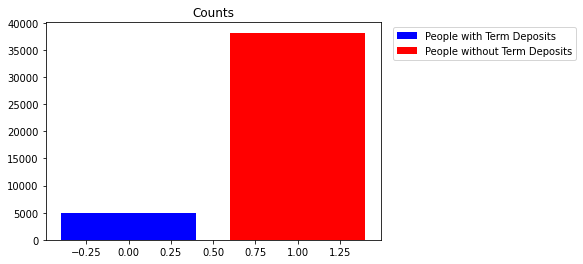

In [ ]:
plt.bar(0, height = no_of_pos_depos , color = 'blue', label = "People with Term Deposits")
plt.bar(1, height = no_of_neg_depos , color = 'red', label = "People without Term Deposits")
# plt.semilogy()
plt.title("Counts")
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper right')
display()

print("People with Term Deposits", no_of_pos_depos)
print("People without Term Deposits", no_of_neg_depos)


##Data Splits

We will check how the different client types are interspersed in each of these two sets - subscribed and not subscribed.

### Marital Status

In [ ]:
marital_term_depos = [(status, len(df_term_deposit_yes[df_term_deposit_yes['marital']== status])) for status in  df['marital'].value_counts().index.values]
marital_term_non_depos = [(status, len(df_term_deposit_no[df_term_deposit_no['marital']== status])) for status in  df['marital'].value_counts().index.values]

In [ ]:
marital_term_non_depos

[('married', 23343), ('single', 10399), ('divorced', 4430)]

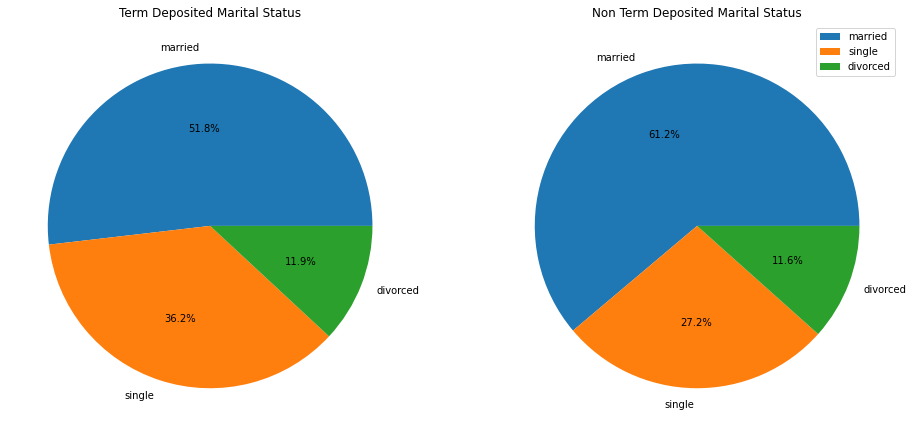

In [ ]:
plt.figure(figsize=(16, 8)) 
    
plt.subplot(1, 2, 1)

vals = [val[1] for val in marital_term_depos]
labels = [val[0] for val in marital_term_depos]
plt.pie(vals, labels = labels, autopct='%1.1f%%')

plt.title("Term Deposited Marital Status")

plt.subplot(1, 2, 2)
vals2 = [val[1] for val in marital_term_non_depos]
labels2 = [val[0] for val in marital_term_non_depos]
plt.pie(vals2, labels = labels2, autopct='%1.1f%%')


plt.title("Non Term Deposited Marital Status")

plt.legend()
display()

### Job


In [ ]:
job_term_depos = [(status, len(df_term_deposit_yes[df_term_deposit_yes['job']== status])) for status in  df_clean['job'].value_counts().index.values]
job_term_non_depos = [(status, len(df_term_deposit_no[df_term_deposit_no['job']== status])) for status in  df_clean['job'].value_counts().index.values]

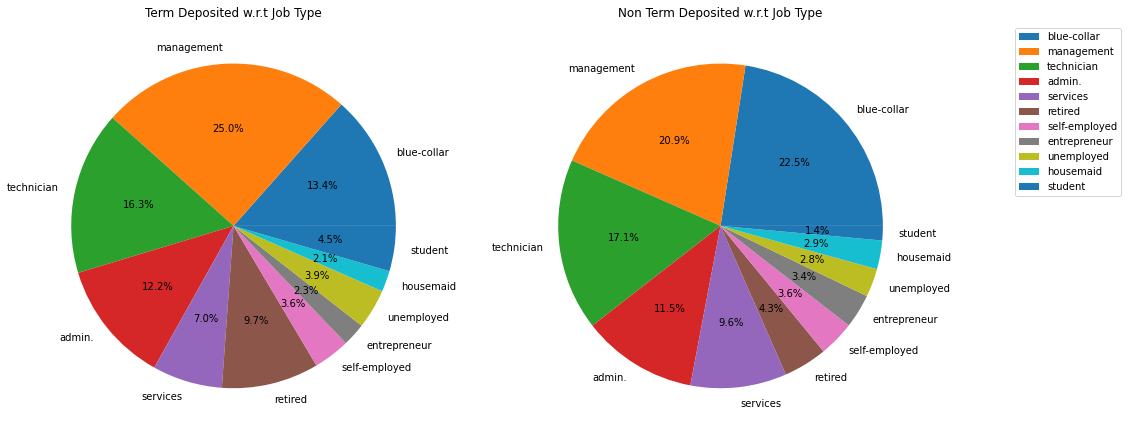

In [ ]:
plt.figure(figsize=(16, 8)) 
    
plt.subplot(1, 2, 1)

vals = [val[1] for val in job_term_depos]
labels = [val[0] for val in job_term_depos]
plt.pie(vals, labels = labels, autopct='%1.1f%%')

plt.title("Term Deposited w.r.t Job Type")


plt.subplot(1, 2, 2)
vals2 = [val[1] for val in job_term_non_depos]
labels2 = [val[0] for val in job_term_non_depos]
plt.pie(vals2, labels = labels2, autopct='%1.1f%%')

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title("Non Term Deposited w.r.t Job Type")

display()

### Loan

In [ ]:
loan_term_depos = [(status, len(df_term_deposit_yes[df_term_deposit_yes['loan']== status])) for status in  df_clean['loan'].value_counts().index.values]
loan_term_non_depos = [(status, len(df_term_deposit_no[df_term_deposit_no['loan']== status])) for status in  df_clean['loan'].value_counts().index.values]

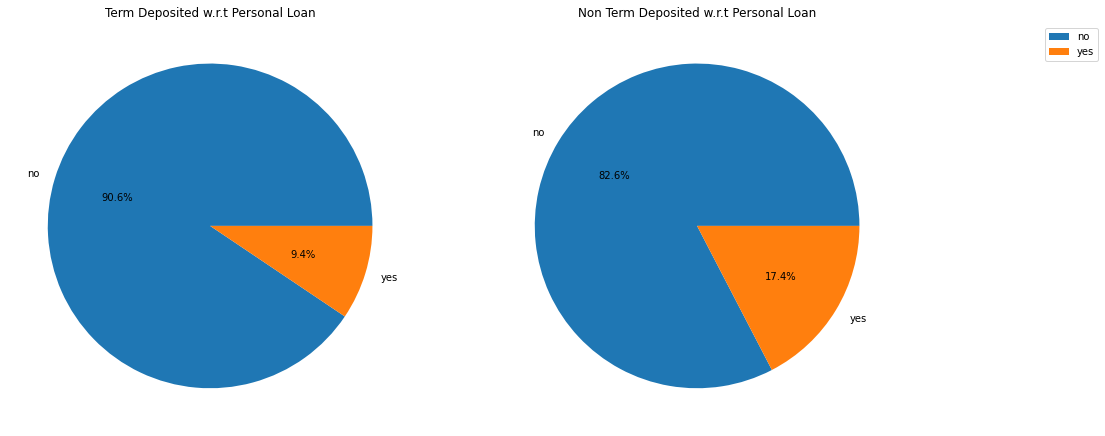

In [ ]:
plt.figure(figsize=(16, 8)) 
    
plt.subplot(1, 2, 1)

vals = [val[1] for val in loan_term_depos]
labels = [val[0] for val in loan_term_depos]
plt.pie(vals, labels = labels, autopct='%1.1f%%')

plt.title("Term Deposited w.r.t Personal Loan")


plt.subplot(1, 2, 2)
vals2 = [val[1] for val in loan_term_non_depos]
labels2 = [val[0] for val in loan_term_non_depos]
plt.pie(vals2, labels = labels2, autopct='%1.1f%%')

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title("Non Term Deposited w.r.t Personal Loan")

display()

What we notice here is that people with no personal loans are more likely to do a Term Deposit. This makes sense as only people with enough excess capital would want to do so

### Housing

In [ ]:
housing_term_depos = [(status, len(df_term_deposit_yes[df_term_deposit_yes['housing']== status])) for status in  df_clean['housing'].value_counts().index.values]
housing_term_non_depos = [(status, len(df_term_deposit_no[df_term_deposit_no['housing']== status])) for status in  df_clean['housing'].value_counts().index.values]

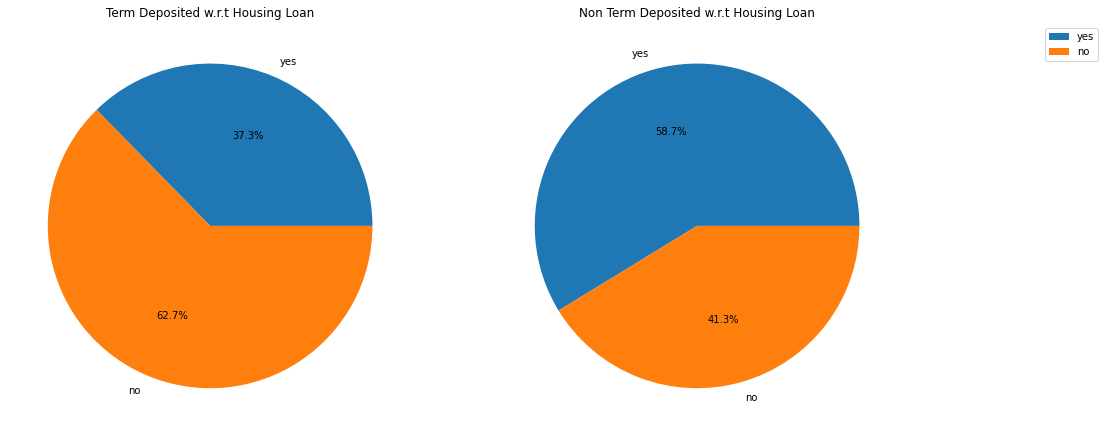

In [ ]:
plt.figure(figsize=(16, 8)) 
    
plt.subplot(1, 2, 1)

vals = [val[1] for val in housing_term_depos]
labels = [val[0] for val in housing_term_depos]
plt.pie(vals, labels = labels, autopct='%1.1f%%')

plt.title("Term Deposited w.r.t Housing Loan")


plt.subplot(1, 2, 2)
vals2 = [val[1] for val in housing_term_non_depos]
labels2 = [val[0] for val in housing_term_non_depos]
plt.pie(vals2, labels = labels2, autopct='%1.1f%%')

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title("Non Term Deposited w.r.t Housing Loan")

display()

What we notice here is that people with no housing loans are more likely to do a Term Deposit.

### Default

In [ ]:
default_term_depos = [(status, len(df_term_deposit_yes[df_term_deposit_yes['default']== status])) for status in  df_clean['default'].value_counts().index.values]
default_term_non_depos = [(status, len(df_term_deposit_no[df_term_deposit_no['default']== status])) for status in  df_clean['default'].value_counts().index.values]

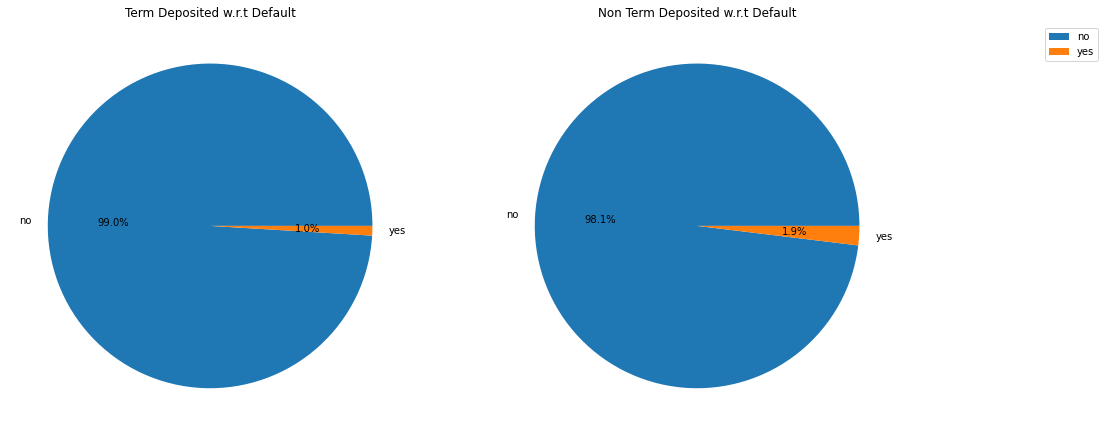

In [ ]:
plt.figure(figsize=(16, 8)) 
    
plt.subplot(1, 2, 1)

vals = [val[1] for val in default_term_depos]
labels = [val[0] for val in default_term_depos]
plt.pie(vals, labels = labels, autopct='%1.1f%%')

plt.title("Term Deposited w.r.t Default")


plt.subplot(1, 2, 2)
vals2 = [val[1] for val in default_term_non_depos]
labels2 = [val[0] for val in default_term_non_depos]
plt.pie(vals2, labels = labels2, autopct='%1.1f%%')

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title("Non Term Deposited w.r.t Default")

display()

### Campaign Frequency

In [ ]:
campaign_term_depos = [(status, len(df_term_deposit_yes[df_term_deposit_yes['Campaign_Freq']== status])) for status in  df_clean['Campaign_Freq'].value_counts().index.values]
campaign_term_non_depos = [(status, len(df_term_deposit_no[df_term_deposit_no['Campaign_Freq']== status])) for status in  df_clean['Campaign_Freq'].value_counts().index.values]

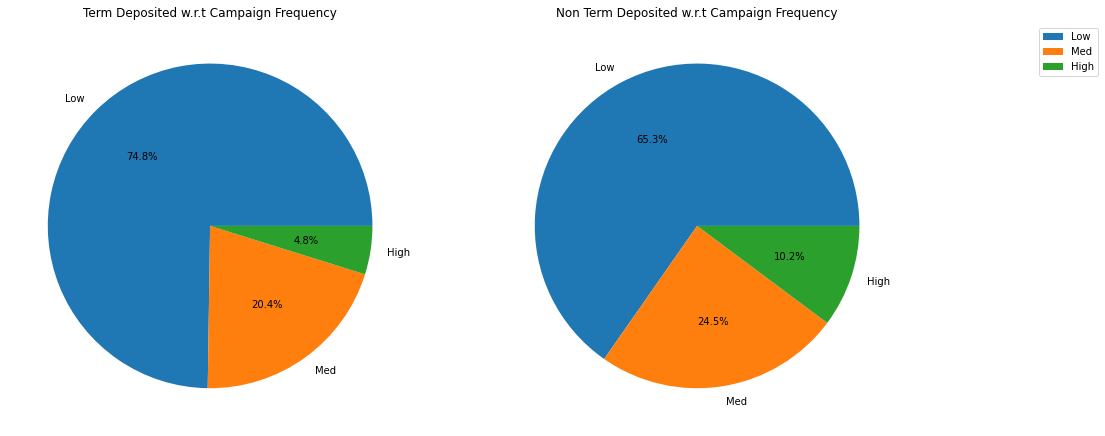

In [ ]:
plt.figure(figsize=(16, 8)) 
    
plt.subplot(1, 2, 1)

vals = [val[1] for val in campaign_term_depos]
labels = [val[0] for val in campaign_term_depos]
plt.pie(vals, labels = labels, autopct='%1.1f%%')

plt.title("Term Deposited w.r.t Campaign Frequency")


plt.subplot(1, 2, 2)
vals2 = [val[1] for val in campaign_term_non_depos]
labels2 = [val[0] for val in campaign_term_non_depos]
plt.pie(vals2, labels = labels2, autopct='%1.1f%%')

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title("Non Term Deposited w.r.t Campaign Frequency")

display()

From the plot a higher Campagin Frequency Seems to be detrimental to getting the person to make a Term Deposit 

## Saving the clean dataframe

In [ ]:
df_clean.to_csv('/content/drive/MyDrive/CS_7290_Project/bank_clean_full.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS_7290_Project/bank_clean.csv', index_col=0)
# df = pd.read_csv('/content/drive/MyDrive/CS_7290_Project/bank.csv', sep=";")
# df= df[features_under_consideration]
df['campaign'] = df['campaign'].apply(lambda x: 0 if x==1 else 1 )
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else 1 )

In [ ]:
df['age'] = df['age'].apply(lambda x: 'young' if x<=25 else 'middle' if x<=50 else 'old')

In [ ]:
df.groupby(['campaign']).count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,pdays,previous,poutcome,y,Campaign_Freq
campaign,,,,,,,,,,,,,,,,,
0,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640,1640
1,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671


In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Campaign_Freq
0,middle,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,0,-1,0,unknown,0,Low
1,middle,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,0,339,4,failure,0,Low
2,middle,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,0,330,1,failure,0,Low
3,middle,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,1,-1,0,unknown,0,Med
4,old,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,0,-1,0,unknown,0,Low


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'Campaign_Freq'],
      dtype='object')

In [ ]:
codes_marital, uniques_marital = pd.factorize(df['marital'].values)
print(codes_marital, uniques_marital)

codes_education, uniques_education = pd.factorize(df['education'].values)
print(codes_education, uniques_education)

codes_job, uniques_job = pd.factorize(df['job'].values)
print(codes_job, uniques_job)

codes_age, uniques_age = pd.factorize(df['age'].values)
print(codes_age, uniques_age)

codes_housing, uniques_housing = pd.factorize(df['housing'].values)
print(codes_housing, uniques_housing)

codes_loan, uniques_loan = pd.factorize(df['loan'].values)
print(codes_loan, uniques_loan)

codes_default, uniques_default = pd.factorize(df['default'].values)
print(codes_default, uniques_default)

[0 0 1 ... 0 0 1] ['married' 'single' 'divorced']
[0 1 2 ... 1 1 2] ['primary' 'secondary' 'tertiary']
[0 1 2 ... 5 3 6] ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired']
[0 0 0 ... 1 0 0] ['middle' 'old' 'young']
[0 1 1 ... 0 0 1] ['no' 'yes']
[0 1 0 ... 0 0 1] ['no' 'yes']
[0 0 0 ... 0 0 0] ['no' 'yes']


In [ ]:
df_independence = df.copy()
df_independence['marital'] = codes_marital
df_independence['education'] = codes_education
df_independence['job'] = codes_job
df_independence['age'] = codes_age
df_independence['housing'] = codes_housing
df_independence['loan'] = codes_loan
df_independence['default'] = codes_default
df_independence= df_independence.rename(columns={"marital": "m", "education": "e", "age": "a", "campaign": "x"})

In [ ]:
df_independence

,a,job,m,e,default,balance,housing,loan,contact,day,month,duration,x,pdays,previous,poutcome,y,Campaign_Freq
0,0,0,0,0,0,1787,0,0,cellular,19,oct,79,0,-1,0,unknown,0,Low
1,0,1,0,1,0,4789,1,1,cellular,11,may,220,0,339,4,failure,0,Low
2,0,2,1,2,0,1350,1,0,cellular,16,apr,185,0,330,1,failure,0,Low
3,0,2,0,2,0,1476,1,1,unknown,3,jun,199,1,-1,0,unknown,0,Med
4,1,3,0,1,0,0,1,0,unknown,5,may,226,0,-1,0,unknown,0,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,0,1,0,1,0,-333,1,0,cellular,30,jul,329,1,-1,0,unknown,0,Med
4517,1,4,0,2,1,-3313,1,1,unknown,9,may,153,0,-1,0,unknown,0,Low
4518,1,5,0,1,0,295,0,0,cellular,19,aug,151,1,-1,0,unknown,0,High
4519,0,3,0,1,0,1137,0,0,cellular,6,feb,129,1,211,3,other,0,Med


#Causal Inference

## Step I Modeling

This is the first and one of the most crucial steps in the whole process. We encode our domain knowledge and insights into a Directed Acyclic Graph(DAG). The nodes respresent different features and the arrows represent the direction of causality. The success of our results depends on the way in which we enocode the assumptions. This steps involved specifying two kinds of variables.

1. **Confounders**: Which are also called common variables. These are variables which act upon both the action and the outcome.
2. **Instrumental Variables**: These are variables that cause the action but have no direct influence on the target variable as such.

In our case we have several confounding variable identified : Job, Balance, Default, Housing, Loan


In [ ]:
causal_graph = """graph [
        directed 1
        node [
            id housing
            label "housing_loan"
        ]
        node [
            id loan
            label "personal_loan"
        ]
        node [
            id default
            label "credit_default"
        ]
        node [
            id y
            label "y"
        ]
        node [
            id x
            label "campaign"
        ]
        node [
            id a
            label "age"
        ]
        node [
            id job
            label "job"
        ]
        node [
            id balance
            label "balance"
        ]
        node [
            id m
            label "marital"
        ]
        node [
            id e
            label "education"
        ]
        edge [
            source a
            target e
        ]
        edge [
            source a
            target m
        ]
        edge [
            source a
            target job
        ]
        edge [
            source e
            target job
        ]
        edge [
            source job
            target loan
        ]
        edge
        [
        source job
        target default
        ]
        edge [
            source job
            target housing
        ]
        edge [
            source job
            target x
        ]
        edge
        [
        source job
        target y
        ]
        edge [
            source job
            target balance
        ]
        edge [
            source housing
            target y
        ]
        edge
        [
        source x
        target y
        ]
                edge [
            source loan
            target y
        ]
        edge [
            source default
            target y
        ]
        edge
        [
        source m
        target y
        ]
        edge
        [
        source balance
        target y
        ]
        edge [
            source balance
            target x
        ]
        edge
        [
        source housing
        target x
        ]
        edge [
            source default
            target x
        ]
        edge [
            source loan
            target x
        ]
        ]"""

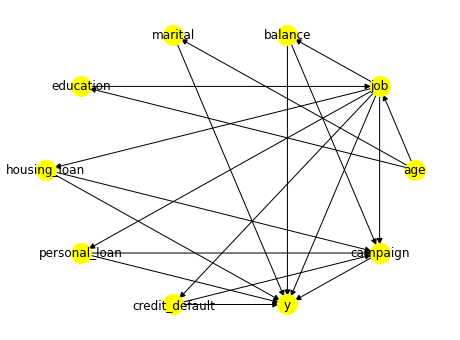

In [ ]:
model = dowhy.CausalModel(data=df_independence,
                          graph=causal_graph,
                          treatment="x",
                          outcome="y")
model.view_model()

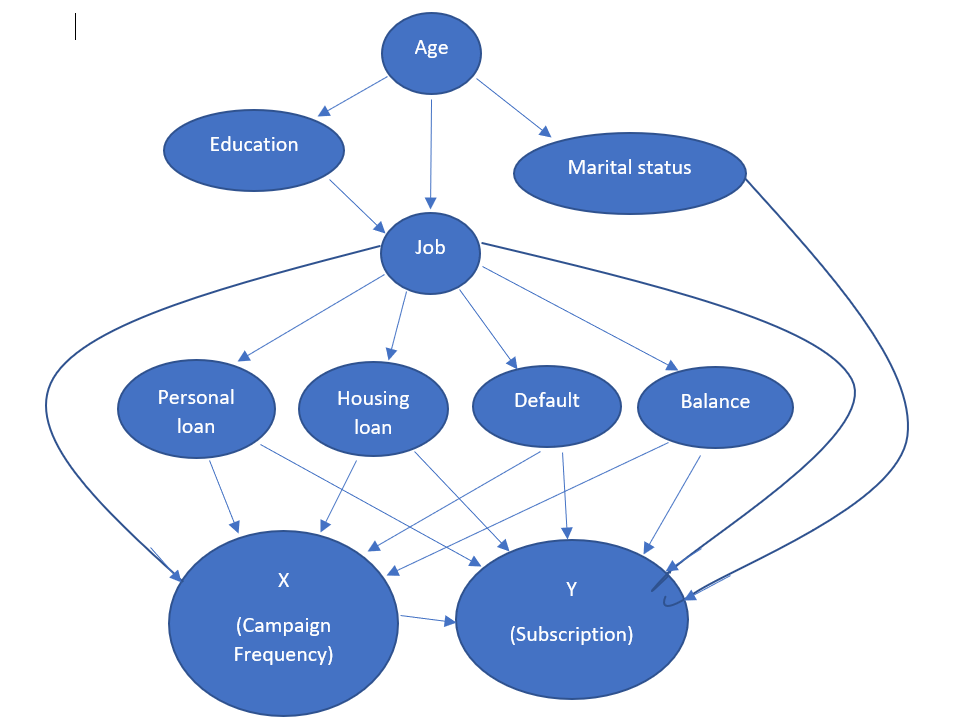

### Step 1a: Testing for Conditional Independence

This a verification step that has been introduced to verify our assumptions of independence encoded into the DAG.
The tests here are to check the if X ⫫ Y | Z where X and Y are singular sets and Z can have k number of variables.

There are several kinds of variable type combinations that we encouter. The test for them are as follows: 
- Continuous data - Partial Correlation<br>
- Discrete data - Conditional Mutual Information<br>
- If Z is continuous/binary and X and Y are either continuous/binary  - Partial Correlation
- When Z is discrete and either of X and Y is continuous - Conditional Mutual Information
- When X and Y are discrete and Z has mixed data - Conditional Mutual Information

#### Testing for a set of edges

In [ ]:
refuter_object = model.refute_graph(independence_constraints = [('x', "m" , ('a','job','housing','loan','balance')),
                                                                ('x', "a" , ('job','housing','loan','balance')),
                                                                ('x', "e" , ('a','job','housing','loan','balance')),
                                                                ('y', "e" , ("m",'a','job','housing','loan','balance')),
                                                                ('y', "a" , ("m",'e','job','housing','loan','balance'))
                                                               ],
                         independence_test = {'test_for_continuous': 'partial_correlation', 'test_for_discrete' : 'conditional_mutual_information'}
                        )

In [ ]:
print(refuter_object)

Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:5
Number of independences satisfied by data:5
Test passed:True



In [ ]:
causal_graph = """digraph {
housing[label="housing_loan"];
loan[label="personal_loan"];
default[label="credit_default"];
y[label="subscribed_for_term_deposit"];
campaign[label="no_of_contacts_made"];
age;
job;
marital;
education;
age->education;
age->job;
age->marital;
education->job;
job->balance;
job->default;
job->loan;
job->housing;
job->campaign;
job->y;
marital->y;
default->y;
default->campaign;
loan->y;
loan->campaign;
housing->y;
housing->campaign;
campaign->y;
balance->y;
balance->campaign;
}"""

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


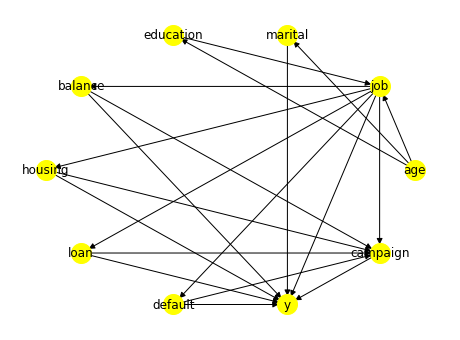

In [ ]:
model = dowhy.CausalModel(data=df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="campaign",
                          outcome="y")
model.view_model()

## Step II. Identification

The process of identification is to investigate whether the observed variables can be used to esimtate the target variable. The identifcation does not rely on the underlying data and just looks into the variables and how they are connected in the causal graph. There are two kinds of identification methods:
1. Backdoor Criteria: This refers to the adjustment set. Here we identify all the common causes and condition upon them. By conditioning we can obtain the causal effect.
2. Instrumental variable identification: Instrumental vairable are those which only affects the target (through another variable which is the treatment variable). Instrument variable can be useful in estimating the effect of the outcome even when all of the other variables are unobserved.

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                      
───────────(Expectation(y|balance,job,housing,default,loan))
d[campaign]                                                 
Estimand assumption 1, Unconfoundedness: If U→{campaign} and U→y then P(y|campaign,balance,job,housing,default,loan,U) = P(y|campaign,balance,job,housing,default,loan)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Step III. Estimation

The next step in our pipeline is the estimation step. In this step, we perform statistical estimation on the estimand that has been identified in the previous step.
Here we try out several such estimators provided by the DoWhy library.

### Method 1: Stratification

We will be using propensity scores to stratify units in the data.

In [ ]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        confidence_intervals=True)
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                      
───────────(Expectation(y|balance,job,housing,default,loan))
d[campaign]                                                 
Estimand assumption 1, Unconfoundedness: If U→{campaign} and U→y then P(y|campaign,balance,job,housing,default,loan,U) = P(y|campaign,balance,job,housing,default,loan)

## Realized estimand
b: y~campaign+balance+job+housing+default+loan
Target units: ate

## Estimate
Mean value: -0.03526334271921232
95.0% confidence interval: (-0.05156209597797272, -0.013794399048502125)

Causal Estimate is -0.03526334271921232


### Method 2: Matching

We will be using propensity scores to match units in the data.

In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching",
        confidence_intervals=True)
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                      
───────────(Expectation(y|balance,job,housing,default,loan))
d[campaign]                                                 
Estimand assumption 1, Unconfoundedness: If U→{campaign} and U→y then P(y|campaign,balance,job,housing,default,loan,U) = P(y|campaign,balance,job,housing,default,loan)

## Realized estimand
b: y~campaign+balance+job+housing+default+loan
Target units: ate

## Estimate
Mean value: -0.05080027835768963
95.0% confidence interval: (-0.07817211783808861, -0.04175365344467641)

Causal Estimate is -0.05080027835768963


### Method 3: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data.

In [ ]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        confidence_intervals=True)
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                      
───────────(Expectation(y|balance,job,housing,default,loan))
d[campaign]                                                 
Estimand assumption 1, Unconfoundedness: If U→{campaign} and U→y then P(y|campaign,balance,job,housing,default,loan,U) = P(y|campaign,balance,job,housing,default,loan)

## Realized estimand
b: y~campaign+balance+job+housing+default+loan
Target units: ate

## Estimate
Mean value: -0.04311799000465952
95.0% confidence interval: (-0.06176901765505115, -0.0240460454728149)

Causal Estimate is -0.04311799000465952



### Method 4: Double Machine Learning

Double machine learning is an estimation technique that is used for estimation when there are a large number of common causes or is of a high dimensionality.

In [ ]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    method_params={
        "init_params":{
            'model_y':GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            "model_final":LassoCV(fit_intercept=False),
            'featurizer':PolynomialFeatures(degree=1, include_bias=False)
        },
        "fit_params":{}
    }
)
print(estimate)
print("The causal effect estimate is " + str(round(estimate.value, 4)))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                      
───────────(Expectation(y|balance,job,housing,default,loan))
d[campaign]                                                 
Estimand assumption 1, Unconfoundedness: If U→{campaign} and U→y then P(y|campaign,balance,job,housing,default,loan,U) = P(y|campaign,balance,job,housing,default,loan)

## Realized estimand
b: y~campaign+balance+job+housing+default+loan | marital
Target units: ate

## Estimate
Mean value: -0.03437791477660133
Effect estimates: [-0.03999506 -0.03999506 -0.02529226 ... -0.03999506 -0.03999506
 -0.02529226]

The causal effect estimate is -0.0344


## Step IV. Refutation

The refutation step is another very important step in the analysis. At this stage we try to estimate the robustness of our causal analysis estimation by several methods. Some of these methods include:
1. Replacing our treatment variable with a random variable.
2. Adding a random cofounding variable
3. Removing a subset of the data


Method 1: Random Common Cause

In [ ]:
random_common_cause_refute_results = model.refute_estimate(identified_estimand, causal_estimate_strat,
                                       method_name="random_common_cause")
print(random_common_cause_refute_results)

Refute: Add a random common cause
Estimated effect:-0.03526334271921232
New effect:-0.03871148310237669
p value:0.15000000000000002



Method 2: Data Subset Refuter

In [ ]:
data_subset_refute_results = model.refute_estimate(identified_estimand, causal_estimate_strat,
                                       method_name="data_subset_refuter")
print(data_subset_refute_results)

Refute: Use a subset of data
Estimated effect:-0.03526334271921232
New effect:-0.035502759516513244
p value:0.49



# Conclusion

The current treatment variable (Campaign Frequency) does not seem to have a direct causal effect on the target variable contrary to our intial assumptions.


#Causal Inference Part 2

In this section we ask another causal question. "How does the marital status affect the chances for a term subscription?"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS_7290_Project/bank_clean.csv', index_col=0)
# df = pd.read_csv('/content/drive/MyDrive/CS_7290_Project/bank.csv', sep=";")
# df= df[features_under_consideration]
df['campaign'] = df['campaign'].apply(lambda x: 0 if x==1 else 1 )
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else 1 )

In [ ]:
df['age'] = df['age'].apply(lambda x: 'young' if x<=25 else 'middle' if x<=50 else 'old')
df['marital'] = df['marital'].apply(lambda x: 'married' if x=="married" else 'umarried')

In [ ]:
df.groupby(['campaign']).count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,pdays,previous,poutcome,y,Campaign_Freq
campaign,,,,,,,,,,,,,,,,,
0,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742,16742
1,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451,26451


In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Campaign_Freq
0,old,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,0,-1,0,unknown,0,Low
1,middle,technician,umarried,secondary,no,29,yes,no,unknown,5,may,151,0,-1,0,unknown,0,Low
2,middle,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,0,-1,0,unknown,0,Low
5,middle,management,married,tertiary,no,231,yes,no,unknown,5,may,139,0,-1,0,unknown,0,Low
6,middle,management,umarried,tertiary,no,447,yes,yes,unknown,5,may,217,0,-1,0,unknown,0,Low


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'Campaign_Freq'],
      dtype='object')

In [ ]:
df['marital'] = df['marital'].apply(lambda x: 'married' if x=="married" else 'umarried')

In [ ]:
codes_marital, uniques_marital = pd.factorize(df['marital'].values)
print(codes_marital, uniques_marital)

codes_education, uniques_education = pd.factorize(df['education'].values)
print(codes_education, uniques_education)

codes_job, uniques_job = pd.factorize(df['job'].values)
print(codes_job, uniques_job)

codes_age, uniques_age = pd.factorize(df['age'].values)
print(codes_age, uniques_age)

codes_housing, uniques_housing = pd.factorize(df['housing'].values)
print(codes_housing, uniques_housing)

codes_loan, uniques_loan = pd.factorize(df['loan'].values)
print(codes_loan, uniques_loan)

codes_default, uniques_default = pd.factorize(df['default'].values)
print(codes_default, uniques_default)

[0 1 0 ... 0 0 0] ['married' 'umarried']
[0 1 1 ... 1 1 1] ['tertiary' 'secondary' 'primary']
[0 1 2 ... 3 6 2] ['management' 'technician' 'entrepreneur' 'retired' 'admin.' 'services'
 'blue-collar' 'self-employed' 'unemployed' 'housemaid' 'student']
[0 1 1 ... 0 0 1] ['old' 'middle' 'young']
[0 0 0 ... 1 1 1] ['yes' 'no']
[0 0 1 ... 0 0 0] ['no' 'yes']
[0 0 0 ... 0 0 0] ['no' 'yes']


In [ ]:
df['marital'] = codes_marital

## Step I Modeling


In [ ]:
model = dowhy.CausalModel(data=df,
                          graph=causal_graph.replace("\n", " "),
                          treatment="marital",
                          outcome="y")

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


## Step II. Identification


In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                         
──────────(Expectation(y|job))
d[marital]                    
Estimand assumption 1, Unconfoundedness: If U→{marital} and U→y then P(y|marital,job,U) = P(y|marital,job)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Step III. Estimation


### Method 1: Stratification
.

In [ ]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        confidence_intervals=True)
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                         
──────────(Expectation(y|job))
d[marital]                    
Estimand assumption 1, Unconfoundedness: If U→{marital} and U→y then P(y|marital,job,U) = P(y|marital,job)

## Realized estimand
b: y~marital+job
Target units: ate

## Estimate
Mean value: 0.034212645306905654
95.0% confidence interval: (0.028115355548113174, 0.039382343767414306)

Causal Estimate is 0.034212645306905654


### Method 2: Matching

In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching",
        confidence_intervals=True)
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                         
──────────(Expectation(y|job))
d[marital]                    
Estimand assumption 1, Unconfoundedness: If U→{marital} and U→y then P(y|marital,job,U) = P(y|marital,job)

## Realized estimand
b: y~marital+job
Target units: ate

## Estimate
Mean value: -0.004283101428472206
95.0% confidence interval: (-0.17301414581066377, 0.08906535781260853)

Causal Estimate is -0.004283101428472206


### Method 3: Weighting

In [ ]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        confidence_intervals=True)
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                         
──────────(Expectation(y|job))
d[marital]                    
Estimand assumption 1, Unconfoundedness: If U→{marital} and U→y then P(y|marital,job,U) = P(y|marital,job)

## Realized estimand
b: y~marital+job
Target units: ate

## Estimate
Mean value: 0.03388120412849109
95.0% confidence interval: (0.027760343436216042, 0.0385773316484149)

Causal Estimate is 0.03388120412849109


### Method 4: Double Machine Learning

In [ ]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    method_params={
        "init_params":{
            'model_y':GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            "model_final":LassoCV(fit_intercept=False),
            'featurizer':PolynomialFeatures(degree=1, include_bias=False)
        },
        "fit_params":{}
    }
)
print(estimate)
print("The causal effect estimate is " + str(round(estimate.value, 4)))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                         
──────────(Expectation(y|job))
d[marital]                    
Estimand assumption 1, Unconfoundedness: If U→{marital} and U→y then P(y|marital,job,U) = P(y|marital,job)

## Realized estimand
b: y~marital+job | loan,default,campaign,job,education,balance,housing
Target units: ate

## Estimate
Mean value: 0.006587591537063149
Effect estimates: [1.04260883e-02 1.41090323e-04 9.73036708e-06 ... 2.78045239e-02
 3.24994260e-03 1.44544603e-02]

The causal effect estimate is 0.0066


## Step IV. Refutation

Method 1: Random Common Cause

In [ ]:
random_common_cause_refute_results = model.refute_estimate(identified_estimand, causal_estimate_strat,
                                       method_name="random_common_cause")
print(random_common_cause_refute_results)

Refute: Add a random common cause
Estimated effect:0.046957080140707826
New effect:0.03342739386324929
p value:0.0



Method 2: Data Subset Refuter

In [ ]:
data_subset_refute_results = model.refute_estimate(identified_estimand, causal_estimate_strat,
                                       method_name="data_subset_refuter")
print(data_subset_refute_results)

Refute: Use a subset of data
Estimated effect:0.046957080140707826
New effect:0.04666810014447061
p value:0.8600000000000001



# Conclusion

The new treatment variable (Marital Status) also does not seem to have a direct causal effect on the target variable.


## Future Scope
* We would like to try this on the bigger dataset which consists of more that 11k data point and see if more data helps.

* We also were trying to figure out on creating a better causal graph which may refelect the actual causality 